In [37]:
import numpy as np
from scipy.stats import pearsonr
from itertools import combinations


class noise(object):
    
    
    def __init__(self, traces, sampleRate, channNames, traceGain = 1.0, freqs = None, time = None, PSD = None \
                , real_PSD = None, imag_PSD = None, corrCoeff = None, unCorrNoise = None, corrNoise = None):
        self.traces = traces # 3d numpy array. dimention zero is number of traces, d-1 is channel number, 
        #d-3 is number of data points per trace
        self.sampleRate = sampleRate
        self.channNames = channNames
        self.time = time # the time series data
        
        self.freqs = freqs
         #list of channel names
        self.traceGain = traceGain #convertion of trace amplitude from ADC bins to amperes 
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        self.corrCoeff = corrCoeff
        self.unCorrNoise = unCorrNoise
        self.corrNoise = corrNoise
        
        
        
    
    def set_freqs(self, freqs):
        self.freqs = freqs
    def set_traceGain(self, traceGain):
        self.traceGain = traceGain
    def set_sampleRate(self, sampleRate):
        self.sampleRate = sampleRate
    def set_channNames(self, channNames):
        self.channNames = channNames
        
    
        
        
    def calculate_freqs(self):
        dt = 1/self.sampleRate
        self.freqs = np.fft.rfftfreq(self.traces.shape[2],d = dt)
        #return self.freqs
    
    def caclulate_PSD(self): 
        # get shape of traces to use for iterating
        traceShape = self.traces.shape
        #check if length of individual trace is odd of even
        if traceShape[2] % 2 != 0:
            lenPSD = int((traceShape[2] + 1)/2)
        else:
            lenPSD = int(traceShape[2]/2 + 1)
            
        # initialize empty numpy array to hold the PSDs 
        PSD = np.empty(shape = (traceShape[1], lenPSD))
        real_PSD = np.empty(shape = (traceShape[1], lenPSD))
        imag_PSD = np.empty(shape = (traceShape[1], lenPSD))
               
        for ichan in range(traceShape[1]):

            fft = np.fft.rfft(self.traces[:,ichan,:])
            PSD_chan = np.abs(fft)**2
            real_PSD_chan = np.real(fft)**2
            imag_PSD_chan = np.imag(fft)**2
                
            # take the average of the PSD's for each trace, normalize, and fold over the 
            # negative frequencies since they are symmetric
            PSD[ichan] = np.mean(PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate) 
            real_PSD[ichan] = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
            imag_PSD[ichan] = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        
    def calculate_corrCoeff(self):
        nsizeMatrix = self.traces.shape[1]
        if self.traces.shape[2] % 2 != 0:
            lenPSD = int((self.traces.shape[2] + 1)/2)
        else:
            lenPSD = int(self.traces.shape[2]/2 + 1)
                
        nDataPoints = self.traces.shape[0]
                                
        #corr_coeff = np.zeros(shape=(nsizeMatrix,nsizeMatrix,lenPSD),dtype = np.float64)              
        traces_fft_chan = np.zeros(shape = (nsizeMatrix,nDataPoints, lenPSD), dtype = np.float64)        
        corr_coeff = np.zeros(shape=(lenPSD,nsizeMatrix,nsizeMatrix),dtype = np.float64) 
        
        for ichan in range(nsizeMatrix):       
            traces_fft_chan[ichan] = np.abs(np.fft.rfft(traces[:,ichan,:]))**2
        
        for n in range(lenPSD):
            corr_coeff[n] = np.corrcoef(traces_fft_chan[:,:,n])
        
        self.corrCoeff = np.swapaxes(corr_coeff, 0, 2)
            


### Load test traces

In [2]:
#with open('/nervascratch/cwfink/Analysis/Runs/SLAC/Run37/noise_traces_PT_on.pkl', 'wb') as f:
#    pkl.load(trace_on_cut, f)
import pickle as pkl    
with open('/nervascratch/cwfink/Analysis/Runs/SLAC/Run37/noise_traces_PT_on.pkl', "rb") as f:
        traces = pkl.load(f,fix_imports=True,encoding='latin1')

In [14]:
sampleRate = 625e3
channels = [ 'PCS1' , 'PES1' , 'PFS1' , 'PAS2' , 'PBS2' , 'PES2' , 'PDS2' ]
g124_noise = noise(traces, sampleRate, channels)


In [28]:
g124_noise.calculate_freqs()
g124_noise.caclulate_PSD()

In [38]:
g124_noise.calculate_corrCoeff()

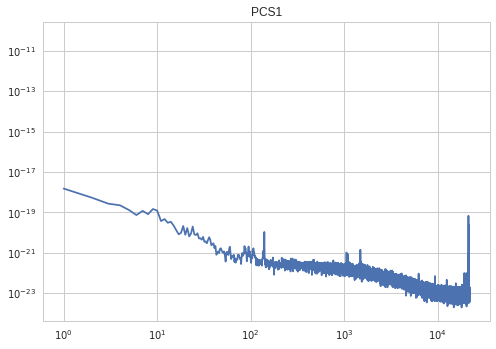

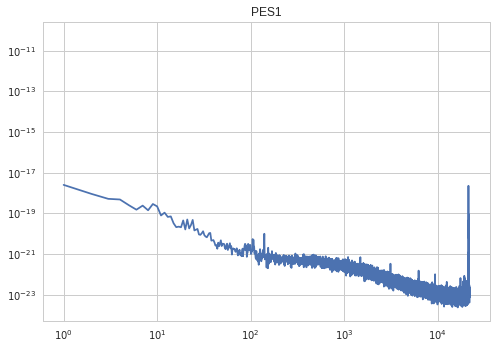

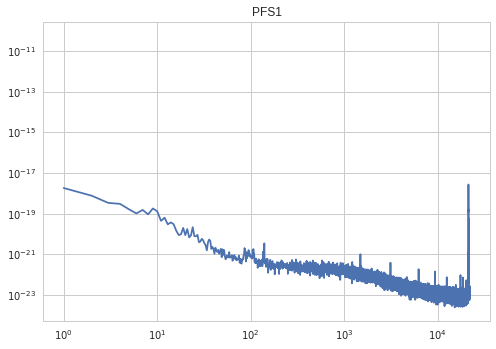

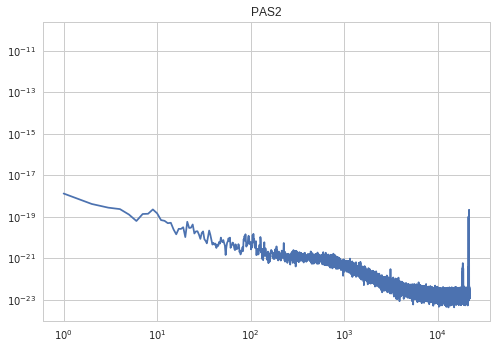

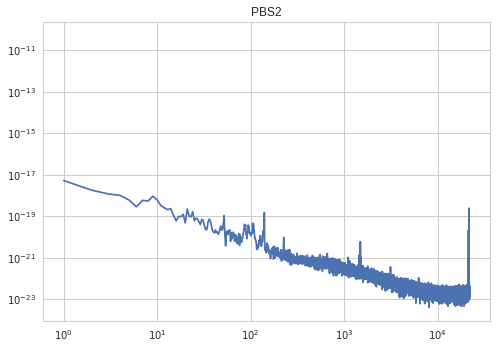

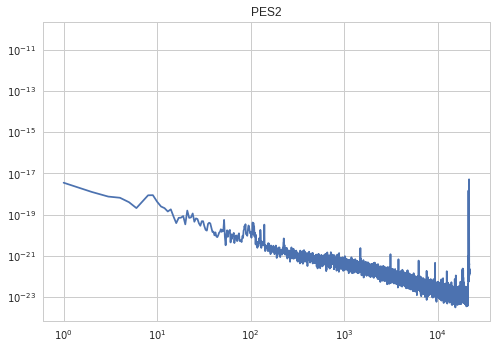

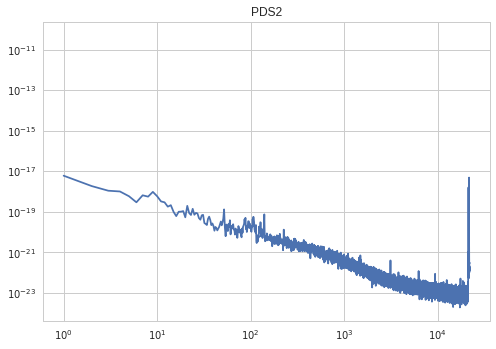

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')


for ichan, PSD in enumerate(g124_noise.imag_PSD):
    plt.figure()
    plt.title(g124_noise.channNames[ichan])
    plt.loglog(PSD)

In [32]:
def print_correlations(freq, CorrCoeff,titleStr, ds=1):
    
    
    nRow = len(CorrCoeff)
    nLen = len(CorrCoeff[0][0])
    
    
    
    title = 'Cross Channel Correlation: G124 SLAC Run 37 ' + titleStr
    plt.figure()
    plt.title(title)
    
    #freq_trunc = freqs#[:nLen/2]
    freq_trunc = freq#[:nLen/2]
    #print(freq)

    
    for iRow in range(nRow):
        for jColumn in range(nRow):
            
            if iRow > jColumn:
            
                label = 'Coeff_' + str(iRow) + str(jColumn)
                #print('x shape: {}'.format(freq_trunc.shape))
                #print('y shape: {}'.format(CorrCoeff[iRow][jColumn].shape))
            
                #plt.plot(freq_trunc, np.abs(corr_coeff[iRow][jColumn][:nLen/2]), label = label)
                #plt.plot(downsample(freq_trunc,ds), downsample(np.abs(CorrCoeff[iRow][jColumn]),ds), label = label)
                plt.plot(freq_trunc, np.abs(CorrCoeff[iRow][jColumn]), label = label)
    plt.legend(loc = 'best')
    #plt.grid()
    plt.xscale('log')
    #plt.ylim(0,1)
    #plt.xlim(10 , 3e5)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Correlation Factor')
    #plt.savefig(pathSave+ 'Figs/Corr_coeff_' + titleStr + '.png')
    plt.show()        
            

In [8]:
def downsample(arr, n):
    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

In [29]:
g124_noise.freqs

array([  0.00000000e+00,   1.42857143e+01,   2.85714286e+01, ...,
         3.12471429e+05,   3.12485714e+05,   3.12500000e+05])

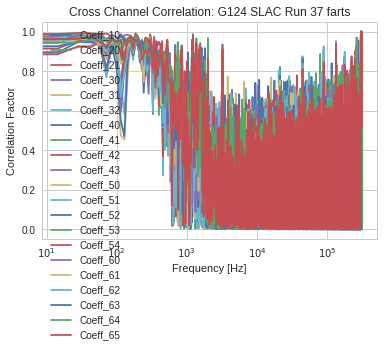

In [45]:
print_correlations(g124_noise.freqs, g124_noise.corrCoeff,titleStr = 'farts', ds=1)

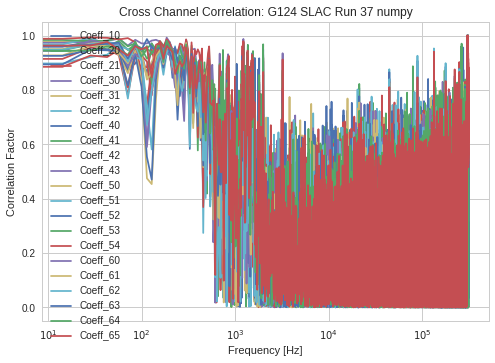

In [39]:
#g124_noise.freqs
print_correlations(g124_noise.freqs, g124_noise.corrCoeff,titleStr = 'numpy', ds=1)